In [24]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

In [25]:
def lowering_a(N):
    ''' Creates the lowering operator for a N-level system '''
    return np.diag(np.sqrt(np.arange(1, N)), 1)
def raising_a(N):
    ''' Creates the raising operator for a N-level system'''
    return np.diag(np.sqrt(np.arange(1, N)), -1)

def System(N, wc, wa, g, alpha):
    ''' Creates the Hamiltonian and the initial state of the system'''
    destruction = np.kron(lowering_a(2), np.eye(N)) #  atomic destruction operator

    num_atm = destruction.T @ destruction # atomic number operator
    num_cav = np.kron(np.eye(2), lowering_a(N).T @ lowering_a(N)) #cavity number operator


    a_dag_X_destruction = np.kron(np.eye(2), lowering_a(N)).T @ destruction # raising times destruction operators
    a_X_creation = np.kron(np.eye(2), lowering_a(N)) @ destruction.T # lowering times creation operators

    H = wc * num_cav + wa * num_atm + g * (a_dag_X_destruction+ a_X_creation) # Hamiltonian

    psi_cav = coherent(N, alpha) # initial state of the cavity

    psi_atm = np.array([[0],[1]])   # initial state of the atom

    psi0 = np.kron(psi_atm, psi_cav) # initial state of the system
    return H, psi0


## Time evolution of ket vector

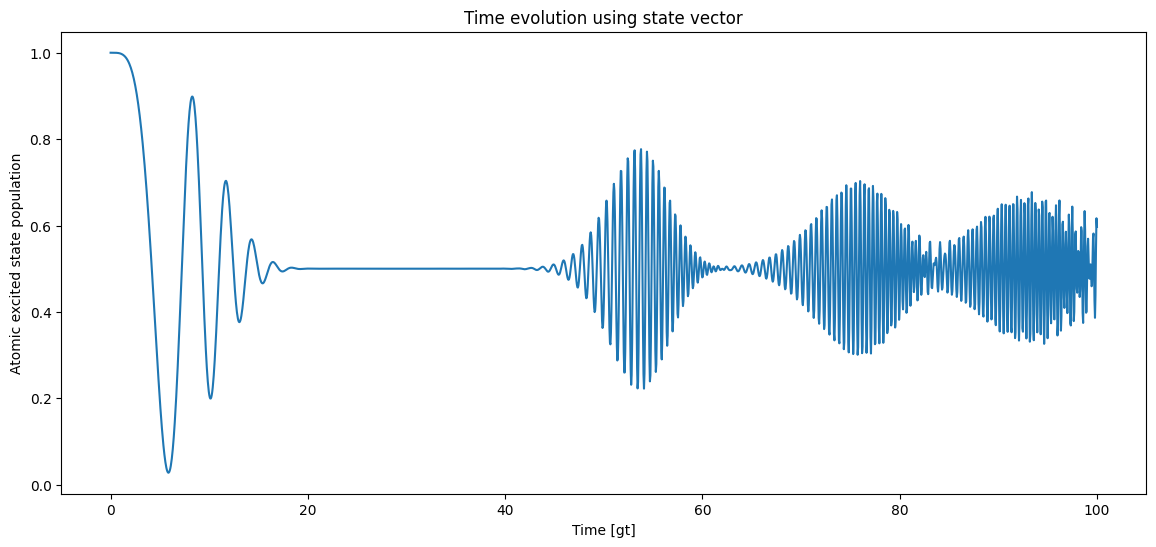

In [36]:
from scipy.linalg import expm

# Define time parameters
N = 40  # Number of photon states in the cavity
destruction = np.kron(lowering_a(2), np.eye(N)) #  atomic destruction operator
num_atm = destruction.T @ destruction # atomic number operator
wc = 1  # Cavity frequency
wa = 1 # Atom frequency
g = .001   # Coupling strength
alpha = np.sqrt(20)  # Initial coherent state amplitude

H, psi0 = System(N, wc, wa, g, alpha)

times = np.linspace(0, 100, 2000)

# Initialize an array to store the expectation values of the number operator
n_expect = np.zeros(len(times))

# Time evolution
psi = psi0
for i, t in enumerate(times):
    # Calculate expectation value of the number operator at each time step
    n_expect[i] = np.real(np.conj(psi.T) @ (num_atm) @ psi)
    
    # Compute the time evolution operator for the given time step
    U = expm(-1j * H * t)
    
    #eigenvalues, eigenvectors = np.linalg.eig(H)
    #exp_eigenvalues = np.exp(-1j*eigenvalues*t)
    #U = eigenvectors @ np.diag(exp_eigenvalues) @ np.linalg.inv(eigenvectors)
    
    # Update the state vector using the time evolution operator
    psi = U @ psi

# Plot the collapse and revival plot
plt.figure(figsize=(14, 6))
plt.plot(times, n_expect)
plt.xlabel('Time [gt]')
plt.ylabel('Atomic excited state population')
plt.title('Time evolution using state vector')
plt.show()


## Time evolution using exact diagonalization

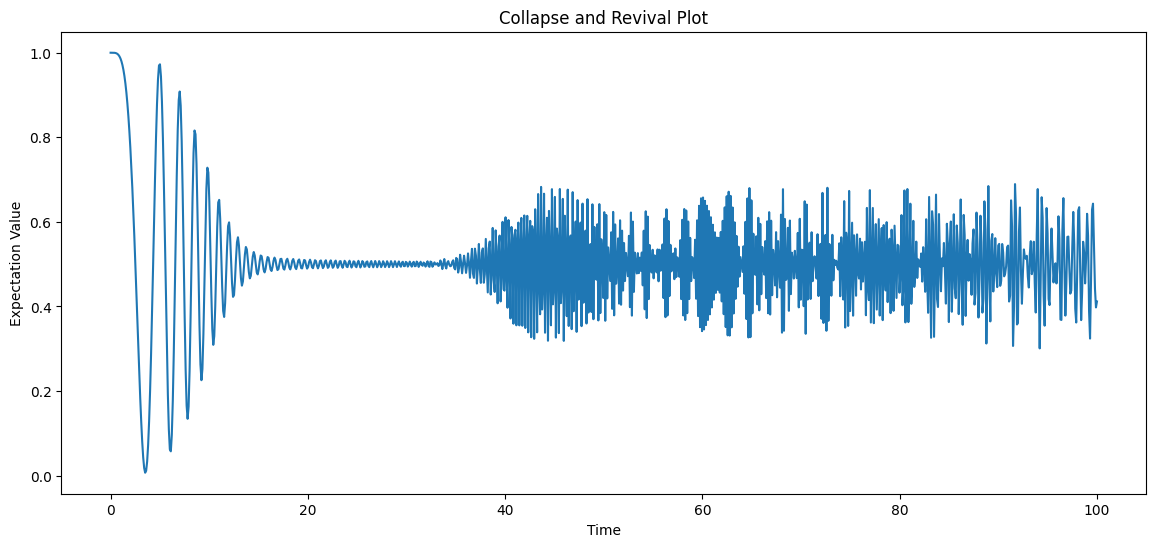

In [41]:
# Define time parameters

N = 40  # Number of photon states in the cavity
destruction = np.kron(lowering_a(2), np.eye(N)) #  atomic destruction operator
num_atm = destruction.T @ destruction # atomic number operator
wc = .0003 # Cavity frequency
wa = .0003 # Atom frequency
g = .006   # Coupling strength
alpha = np.sqrt(20)  # Initial coherent state amplitude

H, psi0 = System(N, wc, wa, g, alpha)

times = np.linspace(0, 100, 1000)

# Initialize an array to store the expectation values of the number operator
n_expect = np.zeros(len(times))

eig, evec = np.linalg.eigh(H)

# Time evolution
psi = psi0
n_expect = np.zeros(len(times))

for i, t in enumerate(times):
    # Calculate expectation value of the number operator at each time step
    n_expect[i] = np.real(np.conj(psi.T) @ (num_atm) @ psi)
    
    # perform time evolution projecting the state onto the eigenbasis
    psi_prime = np.sum([np.exp(-1j * eig[i] * t) * np.outer(vec, vec) @ psi for i,vec in enumerate(evec)], axis=0)
    
    # update the state vector
    psi = psi_prime
    
plt.figure(figsize=(14, 6))
plt.plot(times, n_expect)
plt.xlabel('Time')
plt.ylabel('Atomic excited state population')
plt.title('Collapse and Revival Plot')
plt.show()

## Time evolution using density matrix

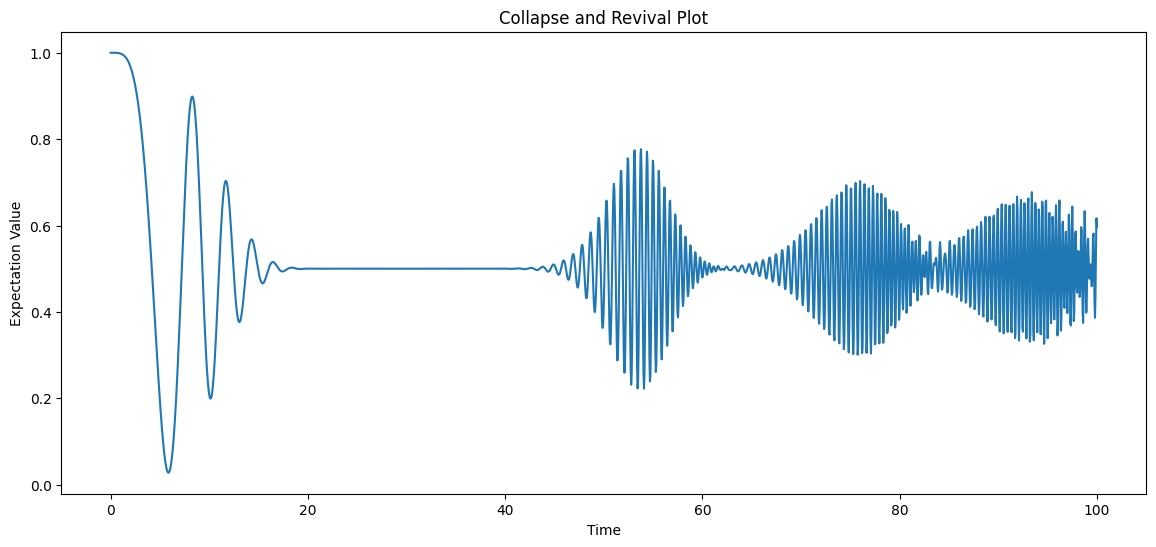

In [58]:
# Define time parameters
N = 40  # Number of photon states in the cavity
destruction = np.kron(lowering_a(2), np.eye(N)) #  atomic destruction operator
num_atm = destruction.T @ destruction # atomic number operator
wc = 1  # Cavity frequency
wa = 1 # Atom frequency
g = .001   # Coupling strength
alpha = np.sqrt(20)  # Initial coherent state amplitude

H, psi0 = System(N, wc, wa, g, alpha)

rho0 = np.outer(psi0, psi0.conj()) # create the density matrix

times = np.linspace(0, 100, 2000)

# Initialize an array to store the expectation values of the number operator
n_expect = np.zeros(len(times))

# Time evolution
rho = rho0
for i, t in enumerate(times):
    # Calculate expectation value of the number operator at each time step
    n_expect[i] = np.trace(np.real(rho @ (num_atm)))
    
    # Compute the time evolution operator for the given time step
    U = expm(-1j * H * t)
    
    # Update the state vector using the time evolution operator
    rho = U @ rho @ U.conj().T

# Plot the collapse and revival plot
plt.figure(figsize=(14, 6))
plt.plot(times, n_expect)
plt.xlabel('Time')
plt.ylabel('Atomic excited state population')
plt.title('Collapse and Revival Plot')
plt.show()


## Time evolution using the Runde-Kutta method.

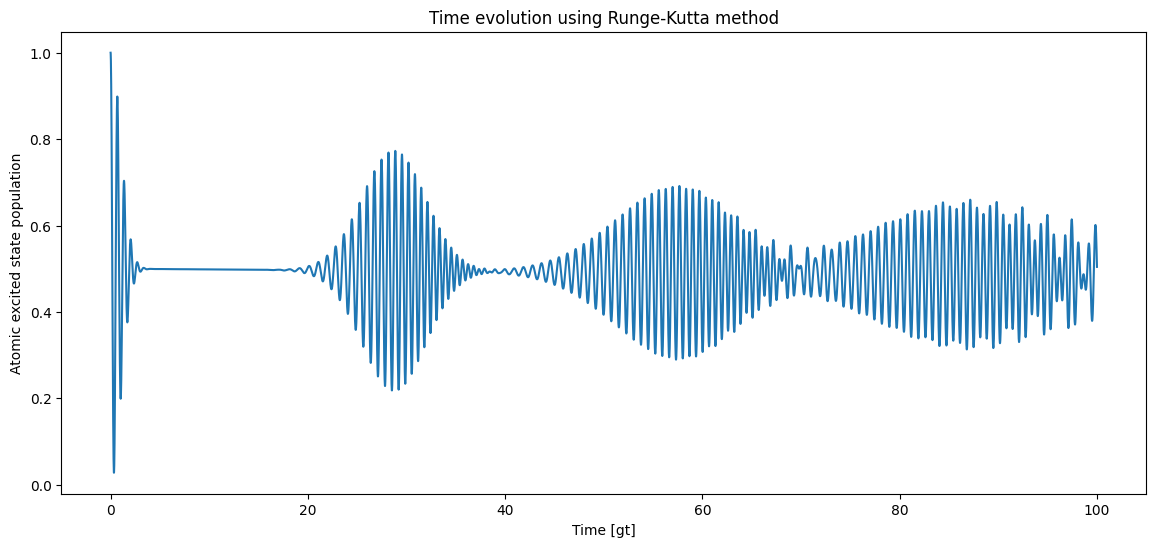

In [35]:

# Define time parameters

N = 40  # Number of photon states in the cavity
destruction = np.kron(lowering_a(2), np.eye(N)) #  atomic destruction operator
num_atm = destruction.T @ destruction # atomic number operator
wc = 1 # Cavity frequency
wa = 1 # Atom frequency
g = 1   # Coupling strength
alpha = np.sqrt(20)  # Initial coherent state amplitude

H, psi0 = System(N, wc, wa, g, alpha)


def rk4_step(f, y, t, dt):
    """Perform a single Runge-Kutta step."""
    k1 = f(y, t)
    k2 = f(y + 0.5*dt*k1, t + 0.5*dt)
    k3 = f(y + 0.5*dt*k2, t + 0.5*dt)
    k4 = f(y + dt*k3, t + dt)
    return y + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)

def hamiltonian(y, t, H):
    """Compute state update term"""
    return -1j*np.dot(H, y)

# Define time parameters
times, dt = np.linspace(0, 100, 10000, retstep=True)

# Initialize an array to store the expectation values of the number operator
n_expect = np.zeros(len(times))

# Time evolution
psi = psi0
for i, t in enumerate(times):
    # Calculate expectation value of the number operator at each time step
    n_expect[i] = np.real(np.conj(psi.T) @ (num_atm) @ psi)
    
    # Perform a single Runge-Kutta step
    psi = rk4_step(lambda psi,t: hamiltonian(psi, t, H), psi, t, dt)

# Plot the collapse and revival plot
plt.figure(figsize=(14, 6))
plt.plot(times, n_expect)
plt.xlabel('Time [gt]')
plt.ylabel('Atomic excited state population')
plt.title('Time evolution using Runge-Kutta method')
plt.show()


## Runde-Kutta with density matrix

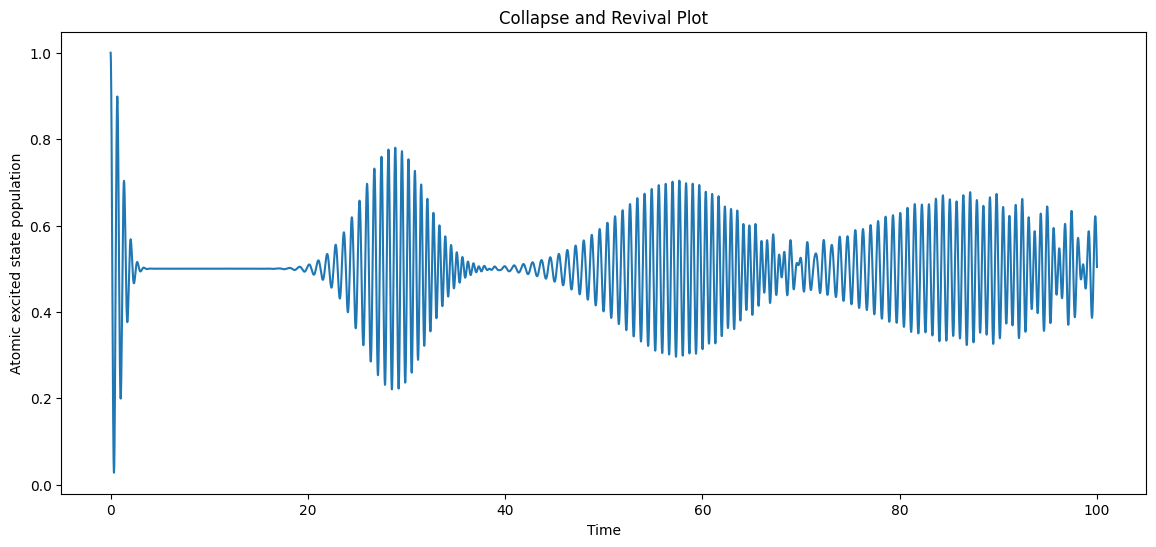

In [34]:

# Define time parameters
N = 40  # Number of photon states in the cavity
destruction = np.kron(lowering_a(2), np.eye(N)) #  atomic destruction operator
num_atm = destruction.T @ destruction # atomic number operator
wc = 1 # Cavity frequency
wa = 1 # Atom frequency
g = 1   # Coupling strength
alpha = np.sqrt(20)  # Initial coherent state amplitude

H, psi0 = System(N, wc, wa, g, alpha)
rho = np.outer(psi0, psi0.conj()) # create the density matrix

def rk4_step(f, y, t, dt):
    """Perform a single Runge-Kutta step."""
    k1 = f(y, t)
    k2 = f(y + 0.5*dt*k1, t + 0.5*dt)
    k3 = f(y + 0.5*dt*k2, t + 0.5*dt)
    k4 = f(y + dt*k3, t + dt)
    return y + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)


def hamiltonian(y, t, H):
    """Compute state update term"""
    return -1j* (np.dot(H, y) - np.dot(y, H))

# Define time parameters
times, dt = np.linspace(0, 100, 10000, retstep=True)

# Initialize an array to store the expectation values of the number operator
n_expect = np.zeros(len(times))

# Time evolution
for i, t in enumerate(times):
    # Calculate expectation value of the number operator at each time step
    n_expect[i] = np.trace(np.real(rho @ (num_atm)))
    
    
    # Perform a single Runge-Kutta step
    rho = rk4_step(lambda rho, t: hamiltonian(rho, t, H), rho, t, dt) 

# Plot the collapse and revival plot
plt.figure(figsize=(14, 6))
plt.plot(times, n_expect)
plt.xlabel('Time')
plt.ylabel('Atomic excited state population')
plt.title('Collapse and Revival Plot')
plt.show()
